In [1]:
!pip install distance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 180.3/180.3 kB 5.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for distance: filename=Distance-0.1.3-py3-none-any.whl size=16258 sha256=1dfd240f3ab5dd6b47d2e54388a3984294a95692fff6b3a93bd87cc3bfd36648
  Stored in directory: /root/.cache/pip/wheels/e8/bb/de/f71bf63559ea9a921059a5405806f7ff6ed612a9231c4a9309
Successfully built distance


## Data Overview
* **`Available Columns:`** id, qid1, qid2, question1, question2, is_duplicate
* **`Class labels:`** 0 - not similar, 1 - similar.
* **`Total training data / No. of rows:`** 404290
* **`No. of columns:`** 5
* is_duplicate is the dependent variable.
* No. of non-duplicate data points is 255027
* No. of duplicate data points is 149263
* We have 404290 training data points. And only 36.92% are positive. That means it is an imbalanced dataset.
* Business Metrics
* It is a binary classification.

## *Importing the Libraries*

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup
import re
import distance
from scipy.spatial.distance import cosine, cityblock, jaccard, canberra, euclidean, minkowski, braycurtis
import scipy

import warnings
warnings.filterwarnings('ignore')

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [3]:
# Loading the data
data = pd.read_csv(r"/content/drive/MyDrive/Colab_Notebooks/train.csv")

In [4]:
# Inspecting the data
data.head()

,qid1,qid2,question1,question2,is_duplicate
0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [5]:
data.info() # Checking the info of the data.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   qid1          404290 non-null  int64 
 1   qid2          404290 non-null  int64 
 2   question1     404289 non-null  object
 3   question2     404288 non-null  object
 4   is_duplicate  404290 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 15.4+ MB


In [6]:
data.describe()

,qid1,qid2,is_duplicate
count,404290.000000,404290.000000,404290.000000
mean,217243.942418,220955.655337,0.369198
std,157751.700002,159903.182629,0.482588
min,1.000000,2.000000,0.000000
25%,74437.500000,74727.000000,0.000000
50%,192182.000000,197052.000000,0.000000
75%,346573.500000,354692.500000,1.000000
max,537932.000000,537933.000000,1.000000


## *Data Cleaning*

In [7]:
data.duplicated().value_counts() # Checking Duplicates

False    404290
dtype: int64

In [8]:
data.isna().sum() # Checking the null values

qid1            0
qid2            0
question1       1
question2       2
is_duplicate    0
dtype: int64

In [9]:
data[data['question1'].isna()] # Identifying the null values in question1.

,qid1,qid2,question1,question2,is_duplicate
363362,493340,493341,NaN,My Chinese name is Haichao Yu. What English na...,0


In [10]:
data[data['question2'].isna()] # Identifying the null values in question2.

,qid1,qid2,question1,question2,is_duplicate
105780,174363,174364,How can I develop android app?,NaN,0
201841,303951,174364,How can I create an Android app?,NaN,0


In [11]:
# filling the null values.
data.loc[201841].values[2]
data.fillna(data.loc[201841].values[2], inplace=True)
data.is_duplicate.loc[105780] = 1
data.is_duplicate.loc[201841] = 1

'How can I create an Android app?'

In [12]:
data.isna().sum()

qid1            0
qid2            0
question1       0
question2       0
is_duplicate    0
dtype: int64

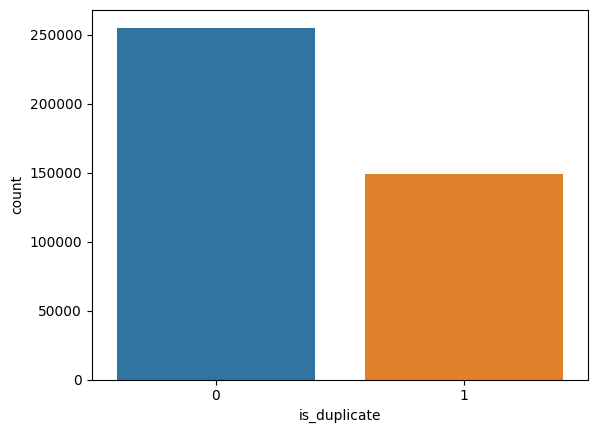

In [13]:
sns.countplot(x=data.is_duplicate);

In [14]:
print('-> Question pairs are not Similar (is_duplicate = 0):\n   {}%'.format(round((data.is_duplicate.value_counts(normalize=True))*100,2)[0]))
print('\n-> Question pairs are Similar (is_duplicate = 1):\n   {}%'.format(round((data.is_duplicate.value_counts(normalize=True))*100,2)[1]))

-> Question pairs are not Similar (is_duplicate = 0):
   63.08%

-> Question pairs are Similar (is_duplicate = 1):
   36.92%


In [15]:
qids = pd.Series(data['qid1'].tolist() + data['qid2'].tolist())
unique_qs = len(np.unique(qids))
qs_morethan_onetime = np.sum(qids.value_counts() > 1)
print ('Total number of  Unique Questions are: {}\n'.format(unique_qs))
#print len(np.unique(qids))

print ('Number of unique questions that appear more than one time: {} ({}%)\n'.format(qs_morethan_onetime,qs_morethan_onetime/unique_qs*100))
print ('Max number of times a single question is repeated: {}\n'.format(max(qids.value_counts()))) 

q_vals=qids.value_counts()
q_vals=q_vals.values

Total number of  Unique Questions are: 537933

Number of unique questions that appear more than one time: 111780 (20.77953945937505%)

Max number of times a single question is repeated: 157



In [16]:
# Dropping the qid1, qid2 columns from the dataframe.
data.drop(['qid1','qid2'], axis=1, inplace=True)

## *Data Prepration - Text Preprocessing*

In [17]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer #From nltk importing stemmer
from nltk.stem import WordNetLemmatizer #From nltk importing lemmatizer
from tqdm import tqdm, tqdm_notebook
tqdm.pandas()# Now you can use `progress_apply` instead of `apply` to track the work.

In [18]:
# Downloading all the required stopwords etc.,.
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [19]:
!pip install fuzzywuzzy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [20]:
# Importing the gensim and from gensim importing word2vec
import gensim
from gensim.models import Word2Vec
from fuzzywuzzy import fuzz

In [21]:
# initialise the inbuilt Stemmer and creating the object
stemmer = PorterStemmer()

# We can also use Lemmatizer instead of Stemmer
lemmatizer = WordNetLemmatizer()

## *Applying the text preprocessing*

In [22]:
def text_preprocess(q):
    # Decontracting words
    contractions = { 
    "ain't": "am not",
    "aren't": "are not",
    "can't": "can not",
    "can't've": "can not have",
    "'cause": "because",
    "could've": "could have",
    "couldn't": "could not",
    "couldn't've": "could not have",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hadn't've": "had not have",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he would",
    "he'd've": "he would have",
    "he'll": "he will",
    "he'll've": "he will have",
    "he's": "he is",
    "how'd": "how did",
    "how'd'y": "how do you",
    "how'll": "how will",
    "how's": "how is",
    "i'd": "i would",
    "i'd've": "i would have",
    "i'll": "i will",
    "i'll've": "i will have",
    "i'm": "i am",
    "i've": "i have",
    "isn't": "is not",
    "it'd": "it would",
    "it'd've": "it would have",
    "it'll": "it will",
    "it'll've": "it will have",
    "it's": "it is",
    "let's": "let us",
    "ma'am": "madam",
    "mayn't": "may not",
    "might've": "might have",
    "mightn't": "might not",
    "mightn't've": "might not have",
    "must've": "must have",
    "mustn't": "must not",
    "mustn't've": "must not have",
    "needn't": "need not",
    "needn't've": "need not have",
    "o'clock": "of the clock",
    "oughtn't": "ought not",
    "oughtn't've": "ought not have",
    "shan't": "shall not",
    "sha'n't": "shall not",
    "shan't've": "shall not have",
    "she'd": "she would",
    "she'd've": "she would have",
    "she'll": "she will",
    "she'll've": "she will have",
    "she's": "she is",
    "should've": "should have",
    "shouldn't": "should not",
    "shouldn't've": "should not have",
    "so've": "so have",
    "so's": "so as",
    "that'd": "that would",
    "that'd've": "that would have",
    "that's": "that is",
    "there'd": "there would",
    "there'd've": "there would have",
    "there's": "there is",
    "they'd": "they would",
    "they'd've": "they would have",
    "they'll": "they will",
    "they'll've": "they will have",
    "they're": "they are",
    "they've": "they have",
    "to've": "to have",
    "wasn't": "was not",
    "we'd": "we would",
    "we'd've": "we would have",
    "we'll": "we will",
    "we'll've": "we will have",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what'll": "what will",
    "what'll've": "what will have",
    "what're": "what are",
    "what's": "what is",
    "what've": "what have",
    "when's": "when is",
    "when've": "when have",
    "where'd": "where did",
    "where's": "where is",
    "where've": "where have",
    "who'll": "who will",
    "who'll've": "who will have",
    "who's": "who is",
    "who've": "who have",
    "why's": "why is",
    "why've": "why have",
    "will've": "will have",
    "won't": "will not",
    "won't've": "will not have",
    "would've": "would have",
    "wouldn't": "would not",
    "wouldn't've": "would not have",
    "y'all": "you all",
    "y'all'd": "you all would",
    "y'all'd've": "you all would have",
    "y'all're": "you all are",
    "y'all've": "you all have",
    "you'd": "you would",
    "you'd've": "you would have",
    "you'll": "you will",
    "you'll've": "you will have",
    "you're": "you are",
    "you've": "you have"
    }

    decontracted = []

    for word in q.split():
        if word in contractions:
            word = contractions[word]

        decontracted.append(word)

    q = ' '.join(decontracted)
    q = q.replace("'ve", " have")
    q = q.replace("n't", " not")
    q = q.replace("'re", " are")
    q = q.replace("'ll", " will")
    
    # Removing HTML tags
    q = BeautifulSoup(q)
    q = q.get_text()
    
    # Remove punctuations
    pattern = re.compile('\W')
    q = re.sub(pattern, ' ', q).strip()

    return q

In [23]:
# Applying the text preprocessing on question1 column.
data['question1'].progress_apply(lambda x: text_preprocess(x))

100%|██████████| 404290/404290 [02:44<00:00, 2452.78it/s]


0         What is the step by step guide to invest in sh...
1         What is the story of Kohinoor  Koh i Noor  Dia...
2         How can I increase the speed of my internet co...
3         Why am I mentally very lonely  How can I solve it
4         Which one dissolve in water quikly sugar  salt...
                                ...                        
404285    How many keywords are there in the Racket prog...
404286             Do you believe there is life after death
404287                                     What is one coin
404288    What is the approx annual cost of living while...
404289                 What is like to have sex with cousin
Name: question1, Length: 404290, dtype: object

In [24]:
# Applying the text preprocessing on question2 column.
data['question2'].progress_apply(lambda x: text_preprocess(x))

100%|██████████| 404290/404290 [02:15<00:00, 2983.51it/s]


0         What is the step by step guide to invest in sh...
1         What would happen if the Indian government sto...
2         How can Internet speed be increased by hacking...
3         Find the remainder when  math 23  24   math  i...
4                    Which fish would survive in salt water
                                ...                        
404285    How many keywords are there in PERL Programmin...
404286            Is it true that there is life after death
404287                                     What s this coin
404288    I am having little hairfall problem but I want...
404289         What is it like to have sex with your cousin
Name: question2, Length: 404290, dtype: object

## *Word2Vec*

In [25]:
import gensim.downloader as api

model = api.load('word2vec-google-news-300') #Downloading the pretained model using api.downloader

[=================================================-] 100.0% 1662.0/1662.8MB downloaded


In [26]:
print(model) #Checking the vector size of the model

KeyedVectors<vector_size=300, 3000000 keys>


In [28]:
def Text2vec(s, flag):
    # Removing special characters and digits
    sentence = re.sub("[^a-zA-Z]", " ", s)
    sentence = sentence.lower() # change sentence to lower case
    tokens = word_tokenize(sentence) # tokenize into words
    words = [t for t in tokens if not t in stopwords.words("english")] # remove stop words   
    words = [w for w in words if w.isalpha()] #Filter out non-alpha characters
    # Stemming/Lemmatization
    if(flag == 'stem'):
        clean_tokens = [stemmer.stem(word) for word in words]
    else:
        clean_tokens = [lemmatizer.lemmatize(word) for word in words]
    V = []
    for x in clean_tokens:#loop through each word in the sentence
        try:
            V.append(model[x])#Gensim model converts each word in the sentence to a 300-dim vector space and appends to a list.
        except:
            continue
    M = np.array(V) #convert the list to array. Shape = (num_of_words_in_sentence,300)
    v = M.sum(axis=0) #Sum up along the num_of_words_in_sentence through 300-dim. Shape = (1,300) 
    return v / np.sqrt((v ** 2).sum()) #normalize the values with the sum

In [30]:
from tqdm import tqdm_notebook #for parallel processing

question1_vectors = np.zeros((data.shape[0], 300)) #vector matrix of shape = (num_of_rows,300) for question 1
for i, x in enumerate(tqdm_notebook(data.question1.values)):
    question1_vectors[i, :] = Text2vec(x, 'lemma') #function call for each question 1
    
question2_vectors  = np.zeros((data.shape[0], 300)) #vector matrix of shape = (num_of_rows,300) for question 2
for i, x in enumerate(tqdm_notebook(data.question2.values)):
    question2_vectors[i, :] = Text2vec(x, 'lemma') #function call for each question 2

  0%|          | 0/404290 [00:00<?, ?it/s]

  0%|          | 0/404290 [00:00<?, ?it/s]

## *Feature extraction*
### *Apply all these feature engineering techniques on the data using the distances*

In [31]:
data['len_q1'] = data.question1.progress_apply(lambda x: len(str(x)))
data['len_q2'] = data.question2.progress_apply(lambda x: len(str(x)))
data['common_words'] = data.progress_apply(lambda x: len(set(str(x['question1']).lower().split()).intersection(set(str(x['question2']).lower().split()))), axis=1)
data['fuzz_ratio'] = data.progress_apply(lambda x: fuzz.ratio(str(x['question1']), str(x['question2'])), axis=1)
data['fuzz_partial_ratio'] = data.progress_apply(lambda x: fuzz.partial_ratio(str(x['question1']), str(x['question2'])), axis=1)
data['fuzz_partial_token_set_ratio'] = data.progress_apply(lambda x: fuzz.partial_token_set_ratio(str(x['question1']), str(x['question2'])), axis=1)
data['fuzz_partial_token_sort_ratio'] = data.progress_apply(lambda x: fuzz.partial_token_sort_ratio(str(x['question1']), str(x['question2'])), axis=1)
data['fuzz_token_set_ratio'] = data.progress_apply(lambda x: fuzz.token_set_ratio(str(x['question1']), str(x['question2'])), axis=1)
data['fuzz_token_sort_ratio'] = data.progress_apply(lambda x: fuzz.token_sort_ratio(str(x['question1']), str(x['question2'])), axis=1)

100%|██████████| 404290/404290 [02:13<00:00, 3021.22it/s]


In [92]:
data['cosine_distance'] = [cosine(x, y) for (x, y) in zip(np.nan_to_num(question1_vectors), np.nan_to_num(question2_vectors))]
data['cityblock_distance'] = [cityblock(x, y) for (x, y) in zip(np.nan_to_num(question1_vectors), np.nan_to_num(question2_vectors))]
data['jaccard_distance'] = [jaccard(x, y) for (x, y) in zip(np.nan_to_num(question1_vectors), np.nan_to_num(question2_vectors))]
data['canberra_distance'] = [canberra(x, y) for (x, y) in zip(np.nan_to_num(question1_vectors), np.nan_to_num(question2_vectors))]
data['euclidean_distance'] = [euclidean(x, y) for (x, y) in zip(np.nan_to_num(question1_vectors), np.nan_to_num(question2_vectors))]
data['minkowski_distance'] = [minkowski(x, y, 3) for (x, y) in zip(np.nan_to_num(question1_vectors), np.nan_to_num(question2_vectors))]
data['braycurtis_distance'] = [braycurtis(x, y) for (x, y) in zip(np.nan_to_num(question1_vectors), np.nan_to_num(question2_vectors))]

In [35]:
data.to_csv('/content/drive/MyDrive/Praveen/final_features.csv', index=False)# Saving the data to csv file.

In [39]:
# Loading the data
quora_df = pd.read_csv('/content/drive/MyDrive/Praveen/final_features.csv')

In [40]:
# Inspecting the data
quora_df.head()

,question1,question2,is_duplicate,len_q1,len_q2,common_words,fuzz_ratio,fuzz_partial_ratio,fuzz_partial_token_set_ratio,fuzz_partial_token_sort_ratio,fuzz_token_set_ratio,fuzz_token_sort_ratio,cosine_distance,cityblock_distance,jaccard_distance,canberra_distance,euclidean_distance,minkowski_distance,braycurtis_distance
0,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,66,57,10,93,98,100,88,100,93,0.068972,5.081614,1.0,94.023324,0.371408,0.168999,0.186557
1,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,51,88,4,65,73,100,73,86,63,0.307825,10.954625,1.0,155.349837,0.784634,0.354073,0.434759
2,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,73,59,4,45,41,100,71,63,63,0.222009,9.055989,1.0,135.988707,0.666346,0.307828,0.342306
3,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,50,65,0,7,20,32,30,28,24,0.654169,15.913837,1.0,191.543720,1.143826,0.509155,0.692948
4,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,76,39,2,37,54,100,67,67,47,0.369993,12.103178,1.0,161.408435,0.860225,0.382770,0.480633


In [41]:
quora_df.drop(['question1','question2'],axis = 1,inplace = True) # Dropping the uncessary columns.

In [42]:
quora_df.head()

,is_duplicate,len_q1,len_q2,common_words,fuzz_ratio,fuzz_partial_ratio,fuzz_partial_token_set_ratio,fuzz_partial_token_sort_ratio,fuzz_token_set_ratio,fuzz_token_sort_ratio,cosine_distance,cityblock_distance,jaccard_distance,canberra_distance,euclidean_distance,minkowski_distance,braycurtis_distance
0,0,66,57,10,93,98,100,88,100,93,0.068972,5.081614,1.0,94.023324,0.371408,0.168999,0.186557
1,0,51,88,4,65,73,100,73,86,63,0.307825,10.954625,1.0,155.349837,0.784634,0.354073,0.434759
2,0,73,59,4,45,41,100,71,63,63,0.222009,9.055989,1.0,135.988707,0.666346,0.307828,0.342306
3,0,50,65,0,7,20,32,30,28,24,0.654169,15.913837,1.0,191.543720,1.143826,0.509155,0.692948
4,0,76,39,2,37,54,100,67,67,47,0.369993,12.103178,1.0,161.408435,0.860225,0.382770,0.480633


In [43]:
quora_df.shape # Checking the shape of the data.

(404290, 17)

In [44]:
quora_df.isna().sum() # Checking the null values are persent.

is_duplicate                       0
len_q1                             0
len_q2                             0
common_words                       0
fuzz_ratio                         0
fuzz_partial_ratio                 0
fuzz_partial_token_set_ratio       0
fuzz_partial_token_sort_ratio      0
fuzz_token_set_ratio               0
fuzz_token_sort_ratio              0
cosine_distance                    0
cityblock_distance                 0
jaccard_distance                   0
canberra_distance                  0
euclidean_distance                 0
minkowski_distance                 0
braycurtis_distance              198
dtype: int64

In [45]:
drop_list = quora_df[quora_df.braycurtis_distance.isna()].index.tolist()# storing the null values into list

In [46]:
quora_df.drop(drop_list, axis = 0, inplace = True) #Dropping the null values

## *Segregating the data*

In [47]:
quora_df.columns # Checking the column names for segregating the data.

Index(['is_duplicate', 'len_q1', 'len_q2', 'common_words', 'fuzz_ratio',
       'fuzz_partial_ratio', 'fuzz_partial_token_set_ratio',
       'fuzz_partial_token_sort_ratio', 'fuzz_token_set_ratio',
       'fuzz_token_sort_ratio', 'cosine_distance', 'cityblock_distance',
       'jaccard_distance', 'canberra_distance', 'euclidean_distance',
       'minkowski_distance', 'braycurtis_distance'],
      dtype='object')

In [48]:
x = quora_df.drop(['is_duplicate', 'jaccard_distance', 'fuzz_partial_token_set_ratio'], axis=1)
y = quora_df['is_duplicate']

## *Splitting into train and test*

In [49]:
# Splitting into train and test.

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [50]:
# Checking the shape of the train and test data.
print('Shape of X_train data: ', X_train.shape)
print('Shape of X_test data: ', X_test.shape)
print('Shape of y_train data: ', y_train.shape)
print('Shape of y_test data: ', y_test.shape)

Shape of X_train data:  (323273, 14)
Shape of X_test data:  (80819, 14)
Shape of y_train data:  (323273,)
Shape of y_test data:  (80819,)


In [51]:
# Importing the StandardScaler to rescaling the numerical data.
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# Rescaling the train Numerical data.
X_train_trans = scaler.fit_transform(X_train)
# Rescaling the train Numerical data.
X_test_trans = scaler.transform(X_test)

# *Model Buliding*

## *Logistic Regression*

In [52]:
from sklearn.linear_model import LogisticRegression
lr_classifier = LogisticRegression()
lr_classifier.fit(X_train_trans, y_train)

LogisticRegression()

In [53]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

print('Train Data Score:')
y_train_pred = lr_classifier.predict(X_train_trans)

print(accuracy_score(y_train, y_train_pred))
print(confusion_matrix(y_train, y_train_pred))
print(classification_report(y_train, y_train_pred))

print('Test Data Score:')
y_test_pred = lr_classifier.predict(X_test_trans)

print(accuracy_score(y_test, y_test_pred))
print(confusion_matrix(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred))

Train Data Score:
0.6666377952999477
[[152362  51375]
 [ 56392  63144]]
              precision    recall  f1-score   support

           0       0.73      0.75      0.74    203737
           1       0.55      0.53      0.54    119536

    accuracy                           0.67    323273
   macro avg       0.64      0.64      0.64    323273
weighted avg       0.66      0.67      0.67    323273

Test Data Score:
0.6684566747918188
[[38309 12846]
 [13949 15715]]
              precision    recall  f1-score   support

           0       0.73      0.75      0.74     51155
           1       0.55      0.53      0.54     29664

    accuracy                           0.67     80819
   macro avg       0.64      0.64      0.64     80819
weighted avg       0.67      0.67      0.67     80819



## *DecisionTree Classifier*

In [54]:
from sklearn.tree import DecisionTreeClassifier
dt_classifier = DecisionTreeClassifier()
dt_classifier.fit(X_train_trans, y_train)

DecisionTreeClassifier()

## *Evaluting the model*

In [55]:
print('Train Data Score:')
y_train_pred = dt_classifier.predict(X_train_trans)

print(accuracy_score(y_train, y_train_pred))
print(confusion_matrix(y_train, y_train_pred))
print(classification_report(y_train, y_train_pred))

print('Test Data Score:')
y_test_pred = dt_classifier.predict(X_test_trans)

print(accuracy_score(y_test, y_test_pred))
print(confusion_matrix(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred))

Train Data Score:
0.9992266598200282
[[203677     60]
 [   190 119346]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    203737
           1       1.00      1.00      1.00    119536

    accuracy                           1.00    323273
   macro avg       1.00      1.00      1.00    323273
weighted avg       1.00      1.00      1.00    323273

Test Data Score:
0.6878333065244558
[[38390 12765]
 [12464 17200]]
              precision    recall  f1-score   support

           0       0.75      0.75      0.75     51155
           1       0.57      0.58      0.58     29664

    accuracy                           0.69     80819
   macro avg       0.66      0.67      0.66     80819
weighted avg       0.69      0.69      0.69     80819



## *AdaBoost Classifier*

In [56]:
from sklearn.ensemble import AdaBoostClassifier
adaclassifier = AdaBoostClassifier()
adaclassifier.fit(X_train_trans, y_train)

AdaBoostClassifier()

## *Evaluting the model*

In [57]:
print('Train Data Score:')
y_train_pred = adaclassifier.predict(X_train_trans)

print(accuracy_score(y_train, y_train_pred))
print(confusion_matrix(y_train, y_train_pred))
print(classification_report(y_train, y_train_pred))

print('Test Data Score:')
y_test_pred = adaclassifier.predict(X_test_trans)

print(accuracy_score(y_test, y_test_pred))
print(confusion_matrix(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred))

Train Data Score:
0.709109637983995
[[149293  54444]
 [ 39593  79943]]
              precision    recall  f1-score   support

           0       0.79      0.73      0.76    203737
           1       0.59      0.67      0.63    119536

    accuracy                           0.71    323273
   macro avg       0.69      0.70      0.70    323273
weighted avg       0.72      0.71      0.71    323273

Test Data Score:
0.7106002301439018
[[37564 13591]
 [ 9798 19866]]
              precision    recall  f1-score   support

           0       0.79      0.73      0.76     51155
           1       0.59      0.67      0.63     29664

    accuracy                           0.71     80819
   macro avg       0.69      0.70      0.70     80819
weighted avg       0.72      0.71      0.71     80819



## *XGBoost Classifier*

In [58]:
import xgboost as xgb
xgclassifier = xgb.XGBClassifier()
xgclassifier.fit(X_train_trans, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

## *Evaluting the model*

In [59]:
print('Train Data Score:')
y_train_pred = xgclassifier.predict(X_train_trans)

print(accuracy_score(y_train, y_train_pred))
print(confusion_matrix(y_train, y_train_pred))
print(classification_report(y_train, y_train_pred))

print('Test Data Score:')
y_test_pred = xgclassifier.predict(X_test_trans)

print(accuracy_score(y_test, y_test_pred))
print(confusion_matrix(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred))

Train Data Score:
0.7539076879293971
[[156816  46921]
 [ 32634  86902]]
              precision    recall  f1-score   support

           0       0.83      0.77      0.80    203737
           1       0.65      0.73      0.69    119536

    accuracy                           0.75    323273
   macro avg       0.74      0.75      0.74    323273
weighted avg       0.76      0.75      0.76    323273

Test Data Score:
0.7391949912768038
[[38896 12259]
 [ 8819 20845]]
              precision    recall  f1-score   support

           0       0.82      0.76      0.79     51155
           1       0.63      0.70      0.66     29664

    accuracy                           0.74     80819
   macro avg       0.72      0.73      0.73     80819
weighted avg       0.75      0.74      0.74     80819



## *GaussianNB Classifier*

In [60]:
from sklearn.naive_bayes import GaussianNB
gnbclassifier = GaussianNB()
gnbclassifier.fit(X_train_trans, y_train)

GaussianNB()

## *Evaluting the model*

In [61]:
print('Train Data Score:')
y_train_pred = gnbclassifier.predict(X_train_trans)

print(accuracy_score(y_train, y_train_pred))
print(confusion_matrix(y_train, y_train_pred))
print(classification_report(y_train, y_train_pred))

print('Test Data Score:')
y_test_pred = gnbclassifier.predict(X_test_trans)

print(accuracy_score(y_test, y_test_pred))
print(confusion_matrix(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred))

Train Data Score:
0.6777893606951401
[[127564  76173]
 [ 27989  91547]]
              precision    recall  f1-score   support

           0       0.82      0.63      0.71    203737
           1       0.55      0.77      0.64    119536

    accuracy                           0.68    323273
   macro avg       0.68      0.70      0.67    323273
weighted avg       0.72      0.68      0.68    323273

Test Data Score:
0.6771056311015974
[[32081 19074]
 [ 7022 22642]]
              precision    recall  f1-score   support

           0       0.82      0.63      0.71     51155
           1       0.54      0.76      0.63     29664

    accuracy                           0.68     80819
   macro avg       0.68      0.70      0.67     80819
weighted avg       0.72      0.68      0.68     80819



## *GradientBoosting Classifier*

In [62]:
from sklearn.ensemble import GradientBoostingClassifier
gbdtclassifier = GradientBoostingClassifier()
gbdtclassifier.fit(X_train_trans, y_train)

GradientBoostingClassifier()

## *Evaluting the model*

In [63]:
print('Train Data Score:')
y_train_pred = gbdtclassifier.predict(X_train_trans)

print(accuracy_score(y_train, y_train_pred))
print(confusion_matrix(y_train, y_train_pred))
print(classification_report(y_train, y_train_pred))

print('Test Data Score:')
y_test_pred = gbdtclassifier.predict(X_test_trans)

print(accuracy_score(y_test, y_test_pred))
print(confusion_matrix(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred))

Train Data Score:
0.7295350988174082
[[151643  52094]
 [ 35340  84196]]
              precision    recall  f1-score   support

           0       0.81      0.74      0.78    203737
           1       0.62      0.70      0.66    119536

    accuracy                           0.73    323273
   macro avg       0.71      0.72      0.72    323273
weighted avg       0.74      0.73      0.73    323273

Test Data Score:
0.7270443831277299
[[38053 13102]
 [ 8958 20706]]
              precision    recall  f1-score   support

           0       0.81      0.74      0.78     51155
           1       0.61      0.70      0.65     29664

    accuracy                           0.73     80819
   macro avg       0.71      0.72      0.71     80819
weighted avg       0.74      0.73      0.73     80819



## *Stacking Classifier*

In [64]:
# Importing the required libraries:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import StackingClassifier
from xgboost import XGBClassifier
#Creating the estimators’ list:

estimators = [
    ('lr', LogisticRegression()),
    ('gnb', GaussianNB()),
    ('dt',DecisionTreeClassifier()),
    ('ada',AdaBoostClassifier())
]
#Applying Stacking:
clf = StackingClassifier(
    estimators=estimators,
    final_estimator=XGBClassifier(),
    cv=10
)
clf.fit(X_train_trans, y_train)

StackingClassifier(cv=10,
                   estimators=[('lr', LogisticRegression()),
                               ('gnb', GaussianNB()),
                               ('dt', DecisionTreeClassifier()),
                               ('ada', AdaBoostClassifier())],
                   final_estimator=XGBClassifier(base_score=None, booster=None,
                                                 callbacks=None,
                                                 colsample_bylevel=None,
                                                 colsample_bynode=None,
                                                 colsample_bytree=None,
                                                 early_stopping_rounds=None,
                                                 enable_categorical=False,
                                                 eval_metr...
                                                 gpu_id=None, grow_policy=None,
                                                 importance_type=None,
                                                 interaction_constraints=None,
                                                 learning_rate=None,
                                                 max_bin=None,
                                                 max_cat_threshold=None,
                                                 max_cat_to_onehot=None,
                                                 max_delta_step=None,
                                                 max_depth=None,
                                                 max_leaves=None,
                                                 min_child_weight=None,
                                                 missing=nan,
                                                 monotone_constraints=None,
                                                 n_estimators=100, n_jobs=None,
                                                 num_parallel_tree=None,
                                                 predictor=None,
                                                 random_state=None, ...))

## *Evaluting the model*

In [65]:
print('Train Data Score:')
y_train_pred = clf.predict(X_train)

print(accuracy_score(y_train, y_train_pred))
print(confusion_matrix(y_train, y_train_pred))
print(classification_report(y_train, y_train_pred))

print('Test Data Score:')
y_test_pred = clf.predict(X_test_trans)

print(accuracy_score(y_test, y_test_pred))
print(confusion_matrix(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred))

Train Data Score:
0.6545025411958314
[[195266   8471]
 [103219  16317]]
              precision    recall  f1-score   support

           0       0.65      0.96      0.78    203737
           1       0.66      0.14      0.23    119536

    accuracy                           0.65    323273
   macro avg       0.66      0.55      0.50    323273
weighted avg       0.66      0.65      0.57    323273

Test Data Score:
0.7164156943293037
[[37478 13677]
 [ 9242 20422]]
              precision    recall  f1-score   support

           0       0.80      0.73      0.77     51155
           1       0.60      0.69      0.64     29664

    accuracy                           0.72     80819
   macro avg       0.70      0.71      0.70     80819
weighted avg       0.73      0.72      0.72     80819



## *DecisionTree Classifier with Hyperparameter*

In [67]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
tuned_parameters = [{'max_depth':[i for i in range(1, 51)]}]

clf = GridSearchCV(
    estimator=DecisionTreeClassifier(), 
    param_grid=tuned_parameters, 
    scoring='f1',
    cv=5,
    return_train_score=True,
    verbose=1
)
clf.fit(X_train_trans, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid=[{'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                        13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                        23, 24, 25, 26, 27, 28, 29, 30, ...]}],
             return_train_score=True, scoring='f1', verbose=1)

## *Evaluting the model*

In [68]:
print('Train Data Score:')
y_train_pred = clf.predict(X_train_trans)

print(accuracy_score(y_train, y_train_pred))
print(confusion_matrix(y_train, y_train_pred))
print(classification_report(y_train, y_train_pred))

print('Test Data Score:')
y_test_pred = clf.predict(X_test_trans)

print(accuracy_score(y_test, y_test_pred))
print(confusion_matrix(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred))

Train Data Score:
0.7358269945216581
[[150498  53239]
 [ 32161  87375]]
              precision    recall  f1-score   support

           0       0.82      0.74      0.78    203737
           1       0.62      0.73      0.67    119536

    accuracy                           0.74    323273
   macro avg       0.72      0.73      0.73    323273
weighted avg       0.75      0.74      0.74    323273

Test Data Score:
0.7261782501639465
[[37479 13676]
 [ 8454 21210]]
              precision    recall  f1-score   support

           0       0.82      0.73      0.77     51155
           1       0.61      0.72      0.66     29664

    accuracy                           0.73     80819
   macro avg       0.71      0.72      0.71     80819
weighted avg       0.74      0.73      0.73     80819



## *Ridge Classifier with Hyperparameter*

In [70]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import RidgeClassifier
tuned_parameters = [{'alpha':[i for i in range(1, 51)]}]

clf = GridSearchCV(
    estimator=RidgeClassifier(), 
    param_grid=tuned_parameters, 
    scoring='f1',
    cv=5,
    return_train_score=True,
    verbose=1
)
clf.fit(X_train_trans, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


GridSearchCV(cv=5, estimator=RidgeClassifier(),
             param_grid=[{'alpha': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,
                                    14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24,
                                    25, 26, 27, 28, 29, 30, ...]}],
             return_train_score=True, scoring='f1', verbose=1)

## *Evaluting the model*

In [71]:
print('Train Data Score:')
y_train_pred = clf.predict(X_train_trans)

print(accuracy_score(y_train, y_train_pred))
print(confusion_matrix(y_train, y_train_pred))
print(classification_report(y_train, y_train_pred))

print('Test Data Score:')
y_test_pred = clf.predict(X_test_trans)

print(accuracy_score(y_test, y_test_pred))
print(confusion_matrix(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred))

Train Data Score:
0.6625205321817782
[[157413  46324]
 [ 62774  56762]]
              precision    recall  f1-score   support

           0       0.71      0.77      0.74    203737
           1       0.55      0.47      0.51    119536

    accuracy                           0.66    323273
   macro avg       0.63      0.62      0.63    323273
weighted avg       0.65      0.66      0.66    323273

Test Data Score:
0.6649426496244695
[[39600 11555]
 [15524 14140]]
              precision    recall  f1-score   support

           0       0.72      0.77      0.75     51155
           1       0.55      0.48      0.51     29664

    accuracy                           0.66     80819
   macro avg       0.63      0.63      0.63     80819
weighted avg       0.66      0.66      0.66     80819



## *RandomForest Classifier*

In [72]:
from sklearn.ensemble import RandomForestClassifier
rfclassifier = RandomForestClassifier()
rfclassifier.fit(X_train_trans, y_train)

RandomForestClassifier()

## *Evaluting the model*

In [73]:
print('Train Data Score:')
y_train_pred = rfclassifier.predict(X_train_trans)

print(accuracy_score(y_train, y_train_pred))
print(confusion_matrix(y_train, y_train_pred))
print(classification_report(y_train, y_train_pred))

print('Test Data Score:')
y_test_pred = rfclassifier.predict(X_test_trans)

print(accuracy_score(y_test, y_test_pred))
print(confusion_matrix(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred))

Train Data Score:
0.9992204730985885
[[203551    186]
 [    66 119470]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    203737
           1       1.00      1.00      1.00    119536

    accuracy                           1.00    323273
   macro avg       1.00      1.00      1.00    323273
weighted avg       1.00      1.00      1.00    323273

Test Data Score:
0.7414964302948565
[[40247 10908]
 [ 9984 19680]]
              precision    recall  f1-score   support

           0       0.80      0.79      0.79     51155
           1       0.64      0.66      0.65     29664

    accuracy                           0.74     80819
   macro avg       0.72      0.73      0.72     80819
weighted avg       0.74      0.74      0.74     80819



In [69]:
from pickle import dump
dump(dt_classifier, open('/content/drive/MyDrive/Colab_Notebooks/dtmodel.pkl', 'wb'))
dump(lr_classifier, open('/content/drive/MyDrive/Colab_Notebooks/lrmodel.pkl', 'wb'))
dump(adaclassifier, open('/content/drive/MyDrive/Colab_Notebooks/adamodel.pkl', 'wb'))
dump(xgclassifier, open('/content/drive/MyDrive/Colab_Notebooks/xgbmodel.pkl', 'wb'))
dump(gnbclassifier, open('/content/drive/MyDrive/Colab_Notebooks/gnbmodel.pkl', 'wb'))
dump(gbdtclassifier, open('/content/drive/MyDrive/Colab_Notebooks/gbdtmodel.pkl', 'wb'))